# VAE Analysis - Faces dataset

## imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.stats import norm
import pandas as pd

from models.VAE import VariationalAutoencoder
from utils.loaders import load_model, ImageLabelLoader

Using TensorFlow backend.


In [4]:
# run params
section = 'vae'
run_id = '0001'
data_name = 'faces'
RUN_FOLDER = 'run/{}/'.format(section)
RUN_FOLDER += '_'.join([run_id, data_name])


DATA_FOLDER = './data/celeb/'
IMAGE_FOLDER = './data/celeb/img_align_celeba/'

## data

In [5]:
INPUT_DIM = (128,128,3)

att = pd.read_csv(os.path.join(DATA_FOLDER, 'list_attr_celeba.csv'))

imageLoader = ImageLabelLoader(IMAGE_FOLDER, INPUT_DIM[:2])


In [6]:
att.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


## architecture

In [7]:
vae = load_model(VariationalAutoencoder, RUN_FOLDER)

W0621 17:03:08.020756 140736265692032 deprecation_wrapper.py:119] From /Users/cenotaph65/miniconda3/envs/generative/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0621 17:03:08.086390 140736265692032 deprecation_wrapper.py:119] From /Users/cenotaph65/miniconda3/envs/generative/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0621 17:03:08.135046 140736265692032 deprecation_wrapper.py:119] From /Users/cenotaph65/miniconda3/envs/generative/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0621 17:03:08.166035 140736265692032 deprecation_wrapper.py:119] From /Users/cenotaph65/miniconda3/envs/generative/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:17

## reconstructing faces

Found 202599 images.


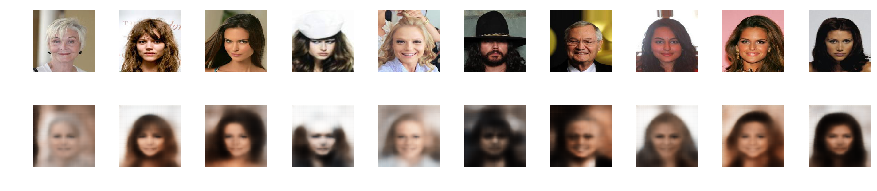

In [8]:
n_to_show = 10

data_flow_generic = imageLoader.build(att, n_to_show)

example_batch = next(data_flow_generic)
example_images = example_batch[0]

z_points = vae.encoder.predict(example_images)

reconst_images = vae.decoder.predict(z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+1)
    sub.axis('off')        
    sub.imshow(img)

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    sub.axis('off')
    sub.imshow(img)


## Latent space distribution

20/20 [==============================] - 6s 293ms/step


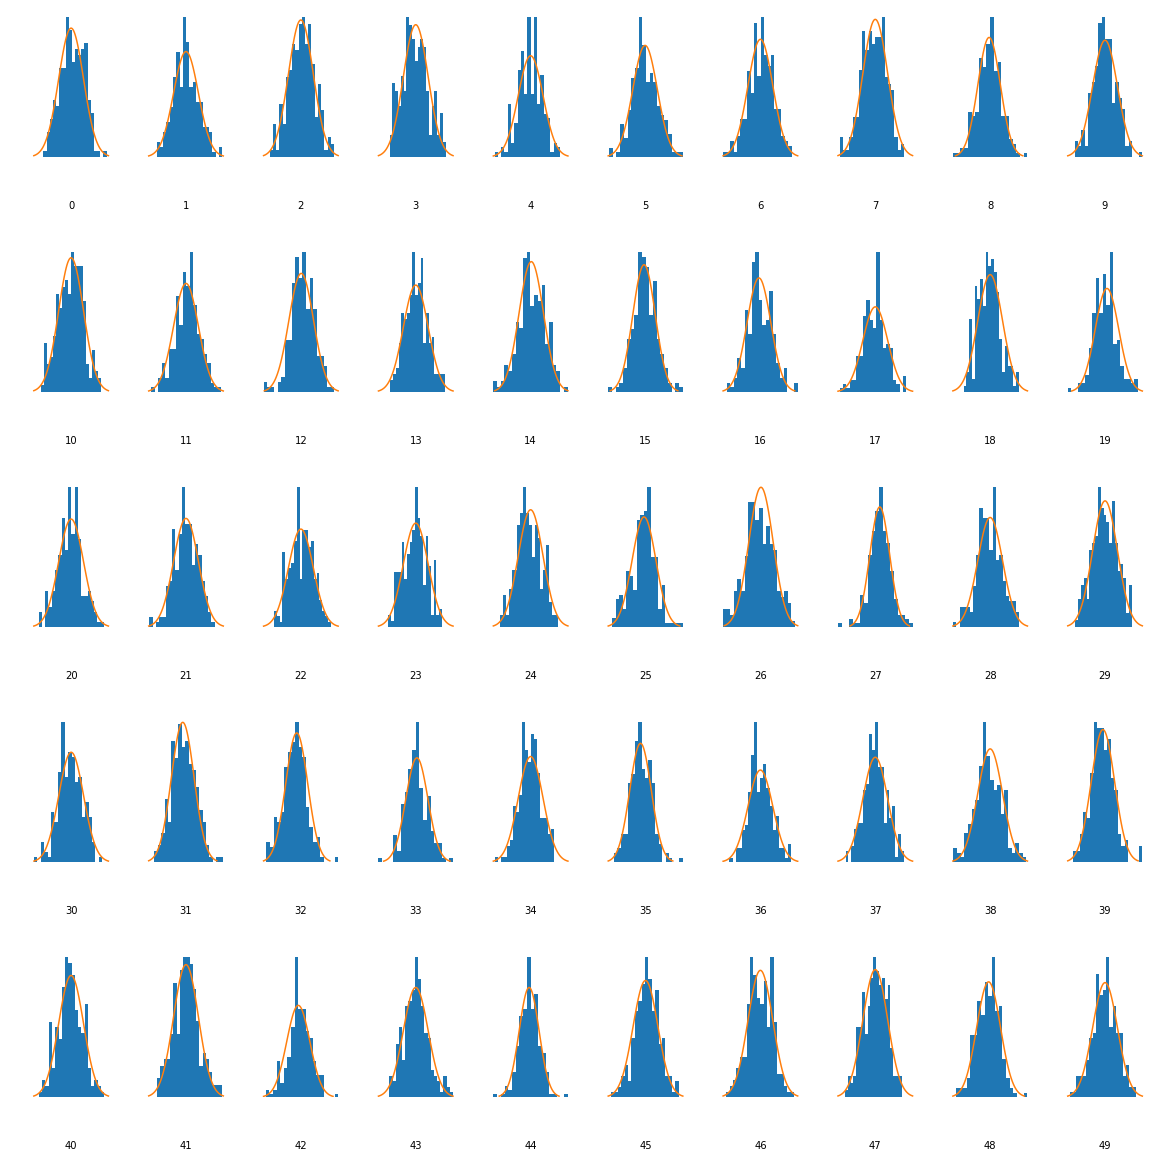

In [9]:
z_test = vae.encoder.predict_generator(data_flow_generic, steps = 20, verbose = 1)

x = np.linspace(-3, 3, 100)

fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(50):
    ax = fig.add_subplot(5, 10, i+1)
    ax.hist(z_test[:,i], density=True, bins = 20)
    ax.axis('off')
    ax.text(0.5, -0.35, str(i), fontsize=10, ha='center', transform=ax.transAxes)
    ax.plot(x,norm.pdf(x))

plt.show()

### Newly generated faces

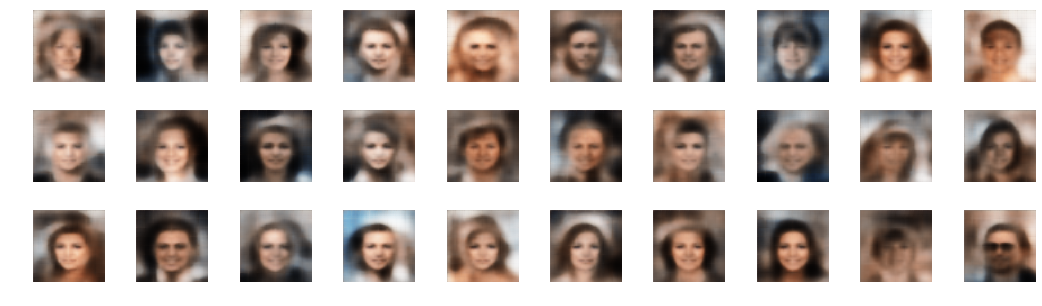

In [10]:
n_to_show = 30

znew = np.random.normal(size = (n_to_show,vae.z_dim))

reconst = vae.decoder.predict(np.array(znew))

fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(n_to_show):
    ax = fig.add_subplot(3, 10, i+1)
    ax.imshow(reconst[i, :,:,:])
    ax.axis('off')

plt.show()

In [11]:
def get_vector_from_label(label, batch_size):

    data_flow_label = imageLoader.build(att, batch_size, label = label)

    origin = np.zeros(shape = vae.z_dim, dtype = 'float32')
    current_sum_POS = np.zeros(shape = vae.z_dim, dtype = 'float32')
    current_n_POS = 0
    current_mean_POS = np.zeros(shape = vae.z_dim, dtype = 'float32')

    current_sum_NEG = np.zeros(shape = vae.z_dim, dtype = 'float32')
    current_n_NEG = 0
    current_mean_NEG = np.zeros(shape = vae.z_dim, dtype = 'float32')

    current_vector = np.zeros(shape = vae.z_dim, dtype = 'float32')
    current_dist = 0

    print('label: ' + label)
    print('images : POS move : NEG move :distance : 𝛥 distance')
    while(current_n_POS < 10000):

        batch = next(data_flow_label)
        im = batch[0]
        attribute = batch[1]

        z = vae.encoder.predict(np.array(im))

        z_POS = z[attribute==1]
        z_NEG = z[attribute==-1]

        if len(z_POS) > 0:
            current_sum_POS = current_sum_POS + np.sum(z_POS, axis = 0)
            current_n_POS += len(z_POS)
            new_mean_POS = current_sum_POS / current_n_POS
            movement_POS = np.linalg.norm(new_mean_POS-current_mean_POS)

        if len(z_NEG) > 0: 
            current_sum_NEG = current_sum_NEG + np.sum(z_NEG, axis = 0)
            current_n_NEG += len(z_NEG)
            new_mean_NEG = current_sum_NEG / current_n_NEG
            movement_NEG = np.linalg.norm(new_mean_NEG-current_mean_NEG)

        current_vector = new_mean_POS-new_mean_NEG
        new_dist = np.linalg.norm(current_vector)
        dist_change = new_dist - current_dist


        print(str(current_n_POS)
              + '    : ' + str(np.round(movement_POS,3))
              + '    : ' + str(np.round(movement_NEG,3))
              + '    : ' + str(np.round(new_dist,3))
              + '    : ' + str(np.round(dist_change,3))
             )

        current_mean_POS = np.copy(new_mean_POS)
        current_mean_NEG = np.copy(new_mean_NEG)
        current_dist = np.copy(new_dist)

        if np.sum([movement_POS, movement_NEG]) < 0.08:
            current_vector = current_vector / current_dist
            print('Found the ' + label + ' vector')
            break

    return current_vector   


In [12]:
def add_vector_to_images(feature_vec):

    n_to_show = 5
    factors = [-4,-3,-2,-1,0,1,2,3,4]

    example_batch = next(data_flow_generic)
    example_images = example_batch[0]
    example_labels = example_batch[1]

    z_points = vae.encoder.predict(example_images)

    fig = plt.figure(figsize=(18, 10))

    counter = 1

    for i in range(n_to_show):

        img = example_images[i].squeeze()
        sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
        sub.axis('off')        
        sub.imshow(img)

        counter += 1

        for factor in factors:

            changed_z_point = z_points[i] + feature_vec * factor
            changed_image = vae.decoder.predict(np.array([changed_z_point]))[0]

            img = changed_image.squeeze()
            sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
            sub.axis('off')
            sub.imshow(img)

            counter += 1

    plt.show()


In [13]:
BATCH_SIZE = 500
attractive_vec = get_vector_from_label('Attractive', BATCH_SIZE)
mouth_open_vec = get_vector_from_label('Mouth_Slightly_Open', BATCH_SIZE)
smiling_vec = get_vector_from_label('Smiling', BATCH_SIZE)
lipstick_vec = get_vector_from_label('Wearing_Lipstick', BATCH_SIZE)
young_vec = get_vector_from_label('High_Cheekbones', BATCH_SIZE)
male_vec = get_vector_from_label('Male', BATCH_SIZE)

Found 202599 images.
label: Attractive
images : POS move : NEG move :distance : 𝛥 distance
267    : 1.39    : 0.972    : 1.736    : 1.736
534    : 0.631    : 0.625    : 1.462    : -0.274
803    : 0.408    : 0.388    : 1.315    : -0.147
1074    : 0.232    : 0.263    : 1.242    : -0.074
1322    : 0.185    : 0.228    : 1.22    : -0.022
1557    : 0.165    : 0.184    : 1.18    : -0.04
1797    : 0.144    : 0.142    : 1.178    : -0.002
2052    : 0.12    : 0.126    : 1.168    : -0.01
2319    : 0.109    : 0.106    : 1.17    : 0.002
2589    : 0.088    : 0.095    : 1.186    : 0.016
2841    : 0.085    : 0.078    : 1.167    : -0.019
3068    : 0.076    : 0.088    : 1.179    : 0.012
3309    : 0.072    : 0.069    : 1.164    : -0.015
3567    : 0.069    : 0.064    : 1.162    : -0.002
3826    : 0.064    : 0.063    : 1.165    : 0.003
4089    : 0.055    : 0.054    : 1.161    : -0.004
4341    : 0.058    : 0.055    : 1.162    : 0.001
4614    : 0.05    : 0.049    : 1.173    : 0.011
4863    : 0.047    : 0.052 

In [14]:
eyeglasses_vec = get_vector_from_label('Eyeglasses', BATCH_SIZE)

Found 202599 images.
label: Eyeglasses
images : POS move : NEG move :distance : 𝛥 distance
35    : 2.718    : 0.769    : 2.852    : 2.852
71    : 1.616    : 0.43    : 2.296    : -0.557
101    : 0.949    : 0.254    : 2.127    : -0.169
133    : 0.626    : 0.181    : 2.031    : -0.096
162    : 0.493    : 0.15    : 2.037    : 0.006
194    : 0.423    : 0.12    : 1.927    : -0.11
231    : 0.396    : 0.105    : 1.931    : 0.005
262    : 0.319    : 0.09    : 1.881    : -0.05
296    : 0.329    : 0.081    : 1.839    : -0.043
333    : 0.282    : 0.06    : 1.803    : -0.036
356    : 0.182    : 0.064    : 1.783    : -0.02
390    : 0.239    : 0.058    : 1.771    : -0.012
427    : 0.197    : 0.05    : 1.764    : -0.007
459    : 0.198    : 0.048    : 1.761    : -0.003
487    : 0.137    : 0.047    : 1.745    : -0.017
511    : 0.131    : 0.044    : 1.744    : -0.0
545    : 0.157    : 0.04    : 1.728    : -0.017
579    : 0.155    : 0.034    : 1.724    : -0.004
603    : 0.118    : 0.036    : 1.711    : -0

In [15]:
blonde_vec = get_vector_from_label('Blond_Hair', BATCH_SIZE)

Found 202599 images.
label: Blond_Hair
images : POS move : NEG move :distance : 𝛥 distance
71    : 2.183    : 0.963    : 2.556    : 2.556
136    : 1.093    : 0.475    : 2.342    : -0.214
216    : 0.668    : 0.27    : 2.26    : -0.082
292    : 0.488    : 0.197    : 2.172    : -0.088
374    : 0.382    : 0.149    : 2.117    : -0.056
448    : 0.281    : 0.132    : 2.089    : -0.027
517    : 0.257    : 0.108    : 2.028    : -0.061
598    : 0.213    : 0.093    : 1.995    : -0.033
678    : 0.204    : 0.088    : 1.979    : -0.015
754    : 0.165    : 0.072    : 1.976    : -0.003
833    : 0.156    : 0.07    : 1.975    : -0.001
904    : 0.14    : 0.061    : 1.975    : -0.0
969    : 0.116    : 0.06    : 1.965    : -0.01
1042    : 0.119    : 0.054    : 1.957    : -0.008
1102    : 0.092    : 0.049    : 1.951    : -0.006
1165    : 0.095    : 0.048    : 1.943    : -0.009
1246    : 0.109    : 0.038    : 1.931    : -0.012
1312    : 0.087    : 0.04    : 1.926    : -0.004
1392    : 0.091    : 0.037    : 1

Attractive Vector


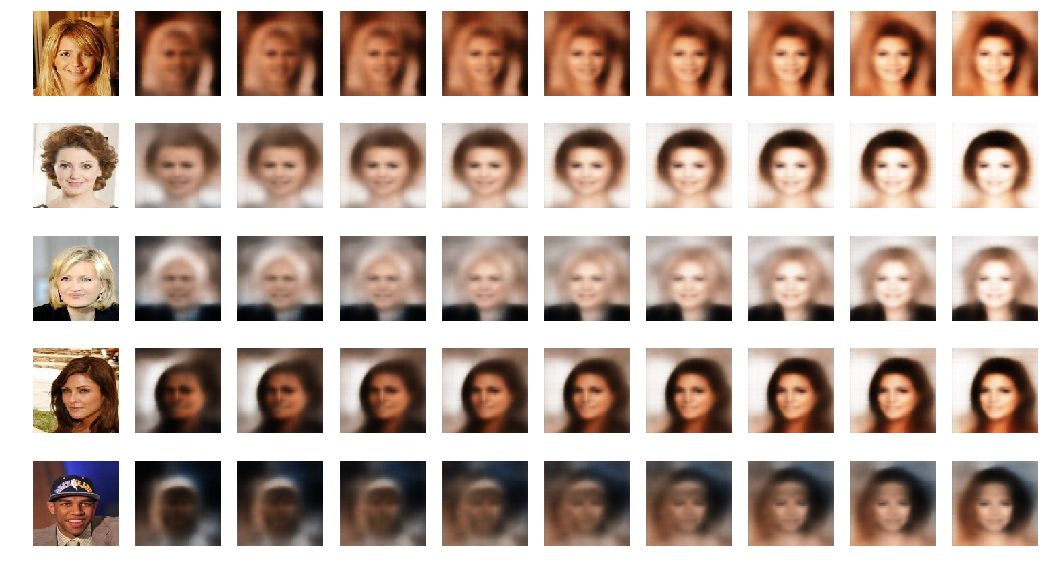

Eyeglasses Vector


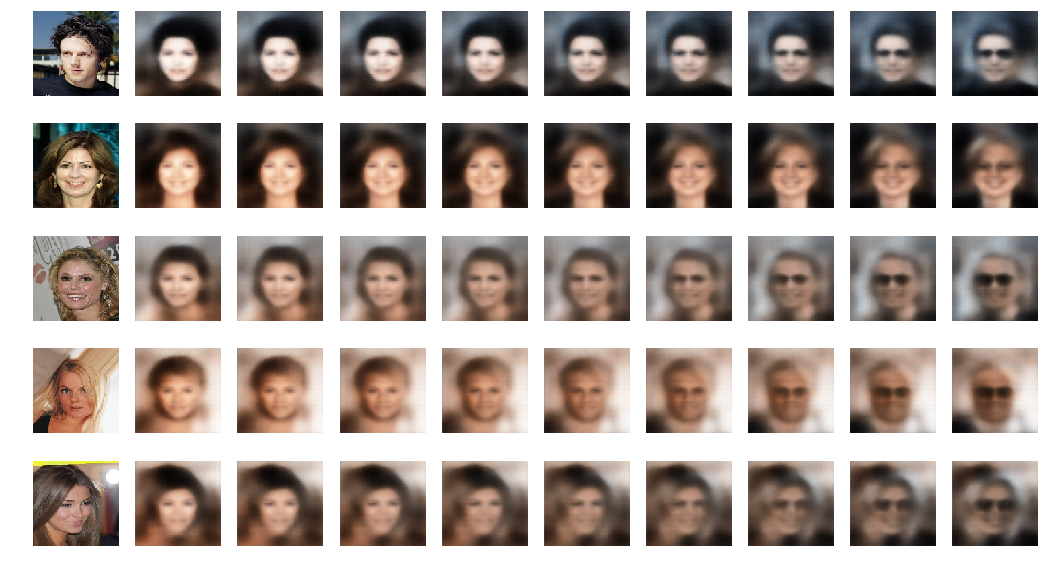

Blond Vector


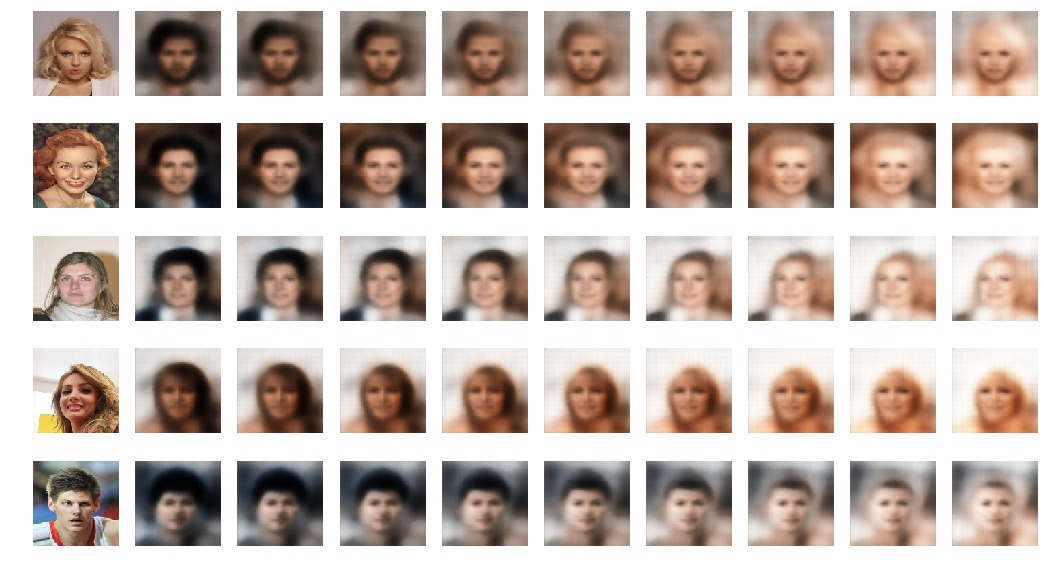

In [22]:
print('Attractive Vector')
add_vector_to_images(attractive_vec)

# print('Mouth Open Vector')
# add_vector_to_images(mouth_open_vec)

# print('Smiling Vector')
# add_vector_to_images(smiling_vec)

# print('Lipstick Vector')
# add_vector_to_images(lipstick_vec)

# print('Young Vector')
# add_vector_to_images(young_vec)

# print('Male Vector')
# add_vector_to_images(male_vec)

print('Eyeglasses Vector')
add_vector_to_images(eyeglasses_vec)

print('Blond Vector')
add_vector_to_images(blonde_vec)

In [23]:

def morph_faces(start_image_file, end_image_file):

    factors = np.arange(0,1,0.1)

    att_specific = att[att['image_id'].isin([start_image_file, end_image_file])]
    att_specific = att_specific.reset_index()
    data_flow_label = imageLoader.build(att_specific, 2)

    example_batch = next(data_flow_label)
    example_images = example_batch[0]
    example_labels = example_batch[1]

    z_points = vae.encoder.predict(example_images)


    fig = plt.figure(figsize=(18, 8))

    counter = 1

    img = example_images[0].squeeze()
    sub = fig.add_subplot(1, len(factors)+2, counter)
    sub.axis('off')        
    sub.imshow(img)

    counter+=1


    for factor in factors:

        changed_z_point = z_points[0] * (1-factor) + z_points[1]  * factor
        changed_image = vae.decoder.predict(np.array([changed_z_point]))[0]

        img = changed_image.squeeze()
        sub = fig.add_subplot(1, len(factors)+2, counter)
        sub.axis('off')
        sub.imshow(img)

        counter += 1

    img = example_images[1].squeeze()
    sub = fig.add_subplot(1, len(factors)+2, counter)
    sub.axis('off')        
    sub.imshow(img)


    plt.show()

Found 2 images.


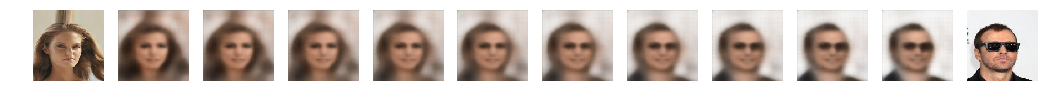

In [24]:
start_image_file = '000238.jpg' 
end_image_file = '000193.jpg' #glasses

morph_faces(start_image_file, end_image_file)

Found 2 images.


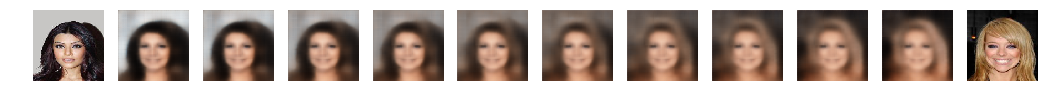

In [25]:
start_image_file = '000112.jpg'
end_image_file = '000258.jpg'

morph_faces(start_image_file, end_image_file)

Found 2 images.


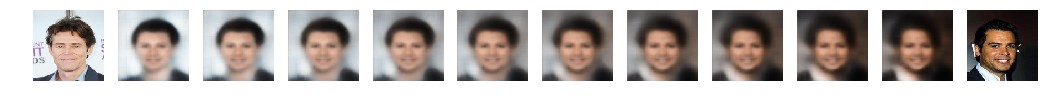

In [26]:
start_image_file = '000230.jpg'
end_image_file = '000712.jpg'

morph_faces(start_image_file, end_image_file)